# Rede com contração e expansão - MNIST

## Importando módulos

In [1]:
import os
import pkgutil

if pkgutil.find_loader('torch') is None:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device:", device)

Device: cuda


## Dataset

In [4]:
dataset_dir = '../data/MNIST/processed/'

### Definição

In [5]:
# Background (non digit) label
keep_non_digit_label = False

In [6]:
def gaussianMap(H, W, sigma, mu):
    x, y = np.meshgrid(np.linspace(-1,1,W), np.linspace(-1,1,H))
    d = np.sqrt(x*x+y*y)
    return np.exp(-((d-mu)**2 / (2.0 * sigma**2)))

In [7]:
class GaussianMNIST(torch.utils.data.Dataset):
    def __init__(self, processed_data_dir, gauss_sigma=1.0, gauss_mu=0.0,
                 non_digit_label=True, numerical_label=False, split=(0.0, 1.0)):
        assert type(split) is tuple, 'Invalid split definition, must be tuple with starting/ending float'
        assert len(split) == 2, 'Invalid split definition, must be tuple with starting/ending float'
        assert (type(split[0]) is float) and (type(split[1]) is float), 'Invalid split definition,\
                                                                         must be tuple with starting/ending float'

        self.non_digit_label = non_digit_label
        self.numerical_label = numerical_label

        test_data, test_label = torch.load(os.path.join(processed_data_dir, 'test.pt'))
        train_data, train_label = torch.load(os.path.join(processed_data_dir, 'training.pt'))

        W = test_data[0].shape[0]
        H = test_data[0].shape[1]
        total_len = len(test_data) + len(train_data)
        start_idx = int(np.ceil(total_len * split[0]))
        end_idx = int(np.ceil(total_len * split[1]))

        self.data = torch.cat((train_data, test_data), dim=0)[start_idx:end_idx].type(torch.FloatTensor) / 255.0
        self.label = torch.cat((train_label, test_label), dim=0)[start_idx:end_idx]

        self.digit_gauss = torch.from_numpy(gaussianMap(H, W, gauss_sigma, gauss_mu)).type(torch.FloatTensor)
        self.non_digit_gauss = 1.0 - self.digit_gauss

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_data = self.data[index].unsqueeze(0)
        
        if self.non_digit_label:
            label_matrix = torch.zeros((11, 28, 28), dtype=torch.float)
            label_matrix[-1] = self.non_digit_gauss
            label_matrix[self.label[index].item()] = self.digit_gauss
        else:
            label_matrix = torch.stack([self.non_digit_gauss / 9.0] * 10, dim=0)
            label_matrix[self.label[index].item()] = 1.0 - (label_matrix[:9].sum(dim=0))

        if self.numerical_label:
            return image_data, label_matrix, self.label[index]
        else:
            return image_data, label_matrix

### Visualização de exemplo

In [8]:
def vizGaussNumber(gauss_image_tensor):
    num_cols = 4

    fig = plt.figure(figsize=(20, 20), edgecolor='black')

    num_imgs = gauss_image_tensor.shape[0]
    num_rows = int(np.ceil(num_imgs/num_cols))

    titles = ['digit'] + list(map(str, range(10)))
    if num_imgs == 12:
        titles += ['background']

    for idx in range(num_imgs):
        ax = fig.add_subplot(num_rows, num_cols, 1 + idx)
        ax.imshow(gauss_image_tensor[idx], cmap='gray')
        ax.set_title(titles[idx])
    plt.show()

In [9]:
def verifySum(gauss_image_tensor):
    gauss_image_tensor_sum = gauss_image_tensor[1:].sum(dim=0)
    print(f'Soma das probabilidades por pixel com valor 1: {torch.sum(gauss_image_tensor_sum == 1.0)}/{28*28}')

In [10]:
non_digit_gauss_dataset = GaussianMNIST(dataset_dir, gauss_sigma=0.8, non_digit_label=keep_non_digit_label)

non_digit_data_tensor, non_digit_label_tensor = non_digit_gauss_dataset[0]
non_digit_gauss_image_tensor = torch.cat((non_digit_data_tensor, non_digit_label_tensor), dim=0)

Soma das probabilidades por pixel com valor 1: 396/784


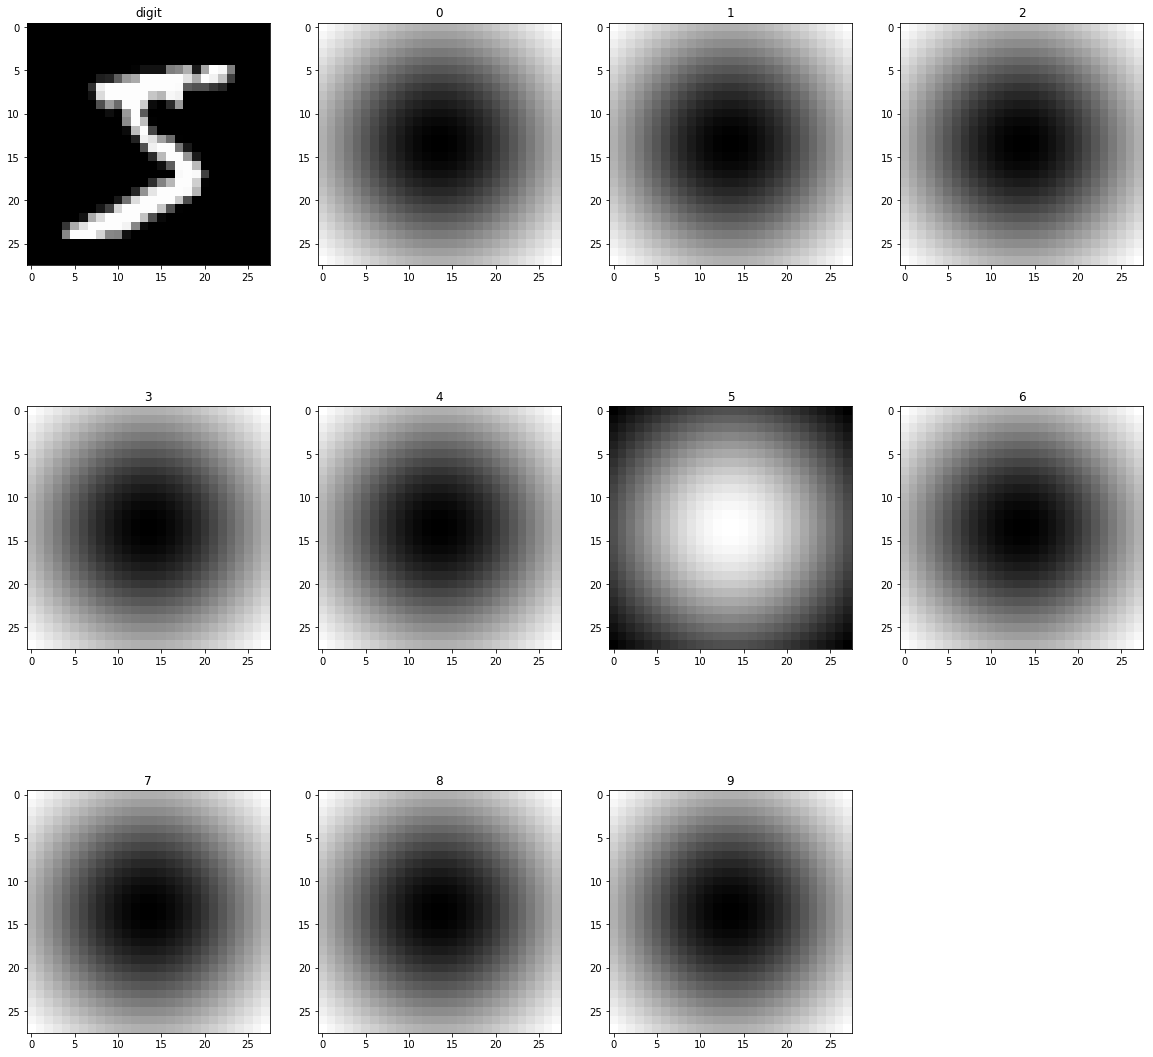

In [11]:
verifySum(non_digit_gauss_image_tensor)
vizGaussNumber(non_digit_gauss_image_tensor)

### Criação dos datasets de Treinamento, Validação e Teste

In [12]:
dataset_train = GaussianMNIST(dataset_dir, gauss_sigma=0.6, split=(0.0, 0.7), non_digit_label=keep_non_digit_label)
dataset_valid = GaussianMNIST(dataset_dir, gauss_sigma=0.6, split=(0.7, 0.9), non_digit_label=keep_non_digit_label)
dataset_test = GaussianMNIST(dataset_dir, gauss_sigma=0.6, split=(0.9, 1.0),
                             numerical_label=True, non_digit_label=keep_non_digit_label)

In [13]:
print(f'Número de amostras para treinamento: {len(dataset_train)}')
print(f'Número de amostras para validação: {len(dataset_valid)}')
print(f'Número de amostras para teste: {len(dataset_test)}')

Número de amostras para treinamento: 49000
Número de amostras para validação: 14000
Número de amostras para teste: 7000


## Dataloaders

In [14]:
batch_size = 64

dataloaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0),
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=0)
}

## Definição do modelo de Rede Neural

In [15]:
class MyModelContractExpand(torch.nn.Module):
    def __init__(self, output_size=11):
        super(MyModelContractExpand, self).__init__()

        channel_array = np.array([2, 4, 6, 8, 7, 5, 3, 1]) * output_size

        self.ce = torch.nn.Sequential(OrderedDict([                                               # 1  x 28 x 28
            ('conv1', torch.nn.Conv2d(in_channels=1,
                                      out_channels=channel_array[0], kernel_size=3)),             # 2*os x 26 x 26
            ('relu1', torch.nn.ReLU()),
            ('conv2', torch.nn.Conv2d(in_channels=channel_array[0],
                                      out_channels=channel_array[1], kernel_size=3)),             # 4*os x 24 x 24
            ('relu2', torch.nn.ReLU()),
            ('conv3', torch.nn.Conv2d(in_channels=channel_array[1],
                                      out_channels=channel_array[2], kernel_size=3)),             # 6*os x 22 x 22
            ('relu3', torch.nn.ReLU()),
            ('conv4', torch.nn.Conv2d(in_channels=channel_array[2],
                                      out_channels=channel_array[3], kernel_size=3)),             # 8*os x 20 x 20
            ('relu4', torch.nn.ReLU()),
            ('transp4', torch.nn.ConvTranspose2d(in_channels=channel_array[3],
                                                 out_channels=channel_array[4], kernel_size=3)),  # 7*os x 22 x 22
            ('relu5', torch.nn.ReLU()),
            ('transp3', torch.nn.ConvTranspose2d(in_channels=channel_array[4],
                                                 out_channels=channel_array[5], kernel_size=3)),  # 5*os x 24 x 24
            ('relu6', torch.nn.ReLU()),
            ('transp2', torch.nn.ConvTranspose2d(in_channels=channel_array[5],
                                                 out_channels=channel_array[6], kernel_size=3)),  # 3*os x 26 x 26
            ('relu7', torch.nn.ReLU()),
            ('transp1', torch.nn.ConvTranspose2d(in_channels=channel_array[6],
                                                 out_channels=channel_array[7], kernel_size=3)),  # 1*os x 28 x 28
            ('softmax', torch.nn.Softmax2d())
        ]))

    def forward(self, x):
        x = self.ce(x)

        return x

### Observando a saida de cada camada

In [16]:
if keep_non_digit_label:
    model_output_size = 11
else:
    model_output_size = 10

model_ce = MyModelContractExpand(output_size=model_output_size).to(device)
x = torch.autograd.Variable(torch.zeros(1, 1, 28, 28)).to(device)

print('{:10}: {}'.format('input', str(x.size())))

for name, layer in model_ce.ce.named_children():
    x = layer(x)

    print('{:10}: {}'.format(name, str(x.size())))

input     : torch.Size([1, 1, 28, 28])
conv1     : torch.Size([1, 20, 26, 26])
relu1     : torch.Size([1, 20, 26, 26])
conv2     : torch.Size([1, 40, 24, 24])
relu2     : torch.Size([1, 40, 24, 24])
conv3     : torch.Size([1, 60, 22, 22])
relu3     : torch.Size([1, 60, 22, 22])
conv4     : torch.Size([1, 80, 20, 20])
relu4     : torch.Size([1, 80, 20, 20])
transp4   : torch.Size([1, 70, 22, 22])
relu5     : torch.Size([1, 70, 22, 22])
transp3   : torch.Size([1, 50, 24, 24])
relu6     : torch.Size([1, 50, 24, 24])
transp2   : torch.Size([1, 30, 26, 26])
relu7     : torch.Size([1, 30, 26, 26])
transp1   : torch.Size([1, 10, 28, 28])
softmax   : torch.Size([1, 10, 28, 28])


## Definição da função de perda - Entropia Cruzada

In [17]:
def myCrossEntropyLoss(target, predict):
    # target: M, 10, 28, 28
    # target: M, 10, 28, 28
    return -(target * torch.log(predict)).sum() * 10.0 / float(np.prod(predict.shape))

## Treinamento

In [18]:
n_epochs = 600

optm = torch.optim.Adam(params=model_ce.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
crit = myCrossEntropyLoss

In [19]:
def train_session(model, dataloaders, num_epochs, optimizer, criterion):
    num_train_samples = len(dataloaders['train'].dataset)
    num_valid_samples = len(dataloaders['valid'].dataset)
    train_batch_size = dataloaders['train'].batch_size
    valid_batch_size = dataloaders['valid'].batch_size

    num_train_batches = num_train_samples // train_batch_size
    num_valid_batches = num_valid_samples // valid_batch_size

    batch_print_size = 10

    epoch_train_loss_history = list()
    epoch_valid_loss_history = list()
    print('Start training for {} epochs'.format(num_epochs))

    try:
        for epoch in range(num_epochs):  # loop over the dataset multiple times
            train_t0 = time.time()
            epoch_train_loss = 0.0
            running_loss = 0.0

            for i, samples in enumerate(dataloaders['train']):
                # get the inputs
                images = samples[0].to(device)
                labels = samples[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model_ce(images)
                loss = criterion(outputs, labels)
                loss_value = loss.cpu().item()
                loss.backward()
                optimizer.step()

                # Update loss totals
                running_loss += loss_value
                epoch_train_loss += loss_value

                # print statistics
                if i % batch_print_size == (batch_print_size - 1):
                    print(f'Train batch {i+1}/{num_train_batches}: loss {running_loss/batch_print_size}', end='\r')
                    running_loss = 0.0

            epoch_train_loss /= num_train_samples
            train_t1 = time.time() - train_t0


            valid_t0 = time.time()
            epoch_valid_loss = 0.0
            running_loss = 0.0

            with torch.no_grad():
                for i, samples in enumerate(dataloaders['valid']):
                    # get the inputs
                    images = samples[0].to(device)
                    labels = samples[1].to(device)

                    # forward
                    outputs = model_ce(images)
                    loss = criterion(outputs, labels)
                    loss_value = loss.cpu().item()

                    # Update loss totals
                    running_loss += loss_value
                    epoch_valid_loss += loss_value

                    # print statistics
                    if i % batch_print_size == (batch_print_size - 1):
                        print(f'Valid batch {i+1}/{num_valid_batches}: loss {running_loss/batch_print_size}', end='\r')
                        running_loss = 0.0

            epoch_valid_loss /= num_valid_samples
            valid_t1 = time.time() - valid_t0

            epoch_train_loss_history.append(epoch_train_loss)
            epoch_valid_loss_history.append(epoch_valid_loss)

            print(f'Epoch {epoch:3d} > train: T={train_t1:5.1f}s | loss={epoch_train_loss}  valid: T={valid_t1:5.1f}s | loss={epoch_valid_loss}')

        print('Finished Training')
    except KeyboardInterrupt:
        print('Finished by user')
        
    return epoch_train_loss_history, epoch_valid_loss_history

In [20]:
def save_loss_history(loss_history_list, loss_history_filename):
    file_obj = open(loss_history_filename, 'w')
    for entry in loss_history_list:
        file_obj.write(str(entry) + '\n')
    file_obj.close()

def load_loss_history(loss_history_filename):
    loss_history_list = list()

    file_obj = open(loss_history_filename, 'r')
    for line in file_obj:
        loss_history_list.append(float(line.strip()))
    file_obj.close()

    return loss_history_list

In [21]:
train = True
epoch_train_loss_history_filename = 'epoch_train_loss_history.txt'
epoch_valid_loss_history_filename = 'epoch_valid_loss_history.txt'

In [22]:
if train:
    epoch_train_loss_history, epoch_valid_loss_history = train_session(model_ce, dataloaders, n_epochs, optm, crit)
    torch.save(model_ce.state_dict(), './model/model_ce')
    save_loss_history(epoch_train_loss_history, epoch_train_loss_history_filename)
    save_loss_history(epoch_valid_loss_history, epoch_valid_loss_history_filename)
else:
    model_ce.load_state_dict(torch.load('./model/model_ce'))
    epoch_train_loss_history = load_loss_history(epoch_train_loss_history_filename)
    epoch_valid_loss_history = load_loss_history(epoch_valid_loss_history_filename)

Start training for 600 epochs
Epoch   0 > train: T= 46.4s | loss=0.04088954184006671  valid: T=  5.1s | loss=0.039768400703157694
Epoch   1 > train: T= 46.2s | loss=0.039252184240185485  valid: T=  5.1s | loss=0.038956881557192125
Epoch   2 > train: T= 46.3s | loss=0.0384080822127206  valid: T=  5.2s | loss=0.038181861826351714
Epoch   3 > train: T= 46.3s | loss=0.03746189587456839  valid: T=  5.1s | loss=0.0370359081029892
Epoch   4 > train: T= 46.3s | loss=0.03656125529444947  valid: T=  5.2s | loss=0.03657080602645874
Epoch   5 > train: T= 46.3s | loss=0.035816196086455365  valid: T=  5.1s | loss=0.035562315225601195
Epoch   6 > train: T= 46.8s | loss=0.03510838189903571  valid: T=  5.1s | loss=0.03475574447427477
Epoch   7 > train: T= 47.0s | loss=0.034357881633602844  valid: T=  5.1s | loss=0.0342128255878176
Epoch   8 > train: T= 46.1s | loss=0.033803754582697035  valid: T=  5.1s | loss=0.03342859081711088
Epoch   9 > train: T= 47.0s | loss=0.03320914357778977  valid: T=  5.5s | 

Epoch  82 > train: T= 46.8s | loss=0.0223836025826785  valid: T=  5.5s | loss=0.022343832799366543
Epoch  83 > train: T= 46.4s | loss=0.02234652562287389  valid: T=  5.6s | loss=0.022523382203919546
Epoch  84 > train: T= 46.5s | loss=0.022337253298078265  valid: T=  5.7s | loss=0.022212690472602846
Epoch  85 > train: T= 47.1s | loss=0.022287906289100646  valid: T=  5.1s | loss=0.022212222763470242
Epoch  86 > train: T= 46.4s | loss=0.02225682461018465  valid: T=  5.9s | loss=0.022227546325751715
Epoch  87 > train: T= 46.8s | loss=0.02220959142032935  valid: T=  5.3s | loss=0.022201242353234972
Epoch  88 > train: T= 46.3s | loss=0.022176713722092765  valid: T=  6.6s | loss=0.02206755142552512
Epoch  89 > train: T= 46.8s | loss=0.022150330176158826  valid: T=  5.3s | loss=0.022010675038610185
Epoch  90 > train: T= 46.7s | loss=0.022126399872254354  valid: T=  5.4s | loss=0.022147782964365825
Epoch  91 > train: T= 46.9s | loss=0.022077254567827498  valid: T=  5.5s | loss=0.022184695703642

Epoch 164 > train: T= 47.0s | loss=0.020831645447380687  valid: T=  5.6s | loss=0.020790188789367677
Epoch 165 > train: T= 46.9s | loss=0.020823327475664566  valid: T=  5.6s | loss=0.02086856972319739
Epoch 166 > train: T= 46.4s | loss=0.020803425538296602  valid: T=  5.7s | loss=0.0208198008111545
Epoch 167 > train: T= 46.1s | loss=0.02079854060679066  valid: T=  5.1s | loss=0.02079334509372711
Epoch 168 > train: T= 47.3s | loss=0.02077047929471853  valid: T=  5.4s | loss=0.0208085726414408
Epoch 169 > train: T= 46.4s | loss=0.02078039966554058  valid: T=  5.6s | loss=0.020915399091584342
Epoch 170 > train: T= 46.7s | loss=0.02075701735944164  valid: T=  5.7s | loss=0.02083191931247711
Epoch 171 > train: T= 46.7s | loss=0.02075587758726003  valid: T=  5.2s | loss=0.020715836797441756
Epoch 172 > train: T= 46.6s | loss=0.020737971442086355  valid: T=  5.4s | loss=0.02076441833802632
Epoch 173 > train: T= 46.9s | loss=0.02072309813450794  valid: T=  5.4s | loss=0.020802472872393472
Epoc

Epoch 246 > train: T= 46.7s | loss=0.020210890862406516  valid: T=  5.2s | loss=0.020361467029367173
Epoch 247 > train: T= 46.6s | loss=0.02020686004113178  valid: T=  5.4s | loss=0.020256299180643898
Epoch 248 > train: T= 46.6s | loss=0.020211308562025732  valid: T=  5.5s | loss=0.02022247734240123
Epoch 249 > train: T= 46.7s | loss=0.02019923942672963  valid: T=  5.6s | loss=0.0202431469304221
Epoch 250 > train: T= 47.0s | loss=0.02019122878629334  valid: T=  5.6s | loss=0.020278038740158082
Epoch 251 > train: T= 46.6s | loss=0.0201712452513831  valid: T=  5.7s | loss=0.020231037514550344
Epoch 252 > train: T= 46.1s | loss=0.020188892347472055  valid: T=  5.3s | loss=0.02025693084512438
Epoch 253 > train: T= 47.3s | loss=0.020182200718899163  valid: T=  5.4s | loss=0.020202674652848925
Epoch 254 > train: T= 46.7s | loss=0.020172939375955233  valid: T=  5.5s | loss=0.02028833201101848
Epoch 255 > train: T= 46.4s | loss=0.0201544771194458  valid: T=  5.7s | loss=0.020357306463377817
Ep

Epoch 328 > train: T= 46.6s | loss=0.019881804853069538  valid: T=  5.5s | loss=0.02005314185789653
Epoch 329 > train: T= 46.9s | loss=0.019870038083621432  valid: T=  5.6s | loss=0.019942158920424325
Epoch 330 > train: T= 46.5s | loss=0.019878159853876854  valid: T=  5.7s | loss=0.02004678918634142
Epoch 331 > train: T= 46.6s | loss=0.01986753910658311  valid: T=  5.2s | loss=0.020021796907697405
Epoch 332 > train: T= 46.5s | loss=0.01987545269849349  valid: T=  5.5s | loss=0.019982996557440076
Epoch 333 > train: T= 46.8s | loss=0.019864071232931955  valid: T=  5.5s | loss=0.02000062415429524
Epoch 334 > train: T= 46.5s | loss=0.019860880078101644  valid: T=  5.7s | loss=0.0199517434324537
Epoch 335 > train: T= 46.9s | loss=0.01985277659795722  valid: T=  5.2s | loss=0.019969437105315072
Epoch 336 > train: T= 46.4s | loss=0.019850179236762376  valid: T=  5.9s | loss=0.02000816995756967
Epoch 337 > train: T= 47.0s | loss=0.01984378928311017  valid: T=  5.3s | loss=0.01997763934305736
E

Epoch 410 > train: T= 46.2s | loss=0.01967333037755927  valid: T=  6.3s | loss=0.019844678802149636
Epoch 411 > train: T= 46.8s | loss=0.01966971786411441  valid: T=  5.6s | loss=0.019872367467199052
Epoch 412 > train: T= 46.5s | loss=0.019663468672304736  valid: T=  5.7s | loss=0.01979675235067095
Epoch 413 > train: T= 46.6s | loss=0.019666667368947243  valid: T=  5.2s | loss=0.019838599477495465
Epoch 414 > train: T= 46.9s | loss=0.01967245824969545  valid: T=  5.4s | loss=0.019832104870251246
Epoch 415 > train: T= 46.2s | loss=0.019661036072945108  valid: T=  6.6s | loss=0.019783560199396952
Epoch 416 > train: T= 47.0s | loss=0.019664049022051752  valid: T=  5.3s | loss=0.019825302490166254
Epoch 417 > train: T= 46.5s | loss=0.019658292271653  valid: T=  5.5s | loss=0.019785457015037537
Epoch 418 > train: T= 46.9s | loss=0.019656074740448778  valid: T=  5.5s | loss=0.019831348615033287
Epoch 419 > train: T= 46.6s | loss=0.019654748252459935  valid: T=  5.7s | loss=0.0198245599525315

Epoch 492 > train: T= 46.8s | loss=0.019528966066788653  valid: T=  5.5s | loss=0.019708615856511253
Epoch 493 > train: T= 46.5s | loss=0.019532770332025023  valid: T=  5.6s | loss=0.019790135264396668
Epoch 494 > train: T= 46.9s | loss=0.01951935488837106  valid: T=  5.6s | loss=0.01972680393287114
Epoch 495 > train: T= 46.6s | loss=0.019532788821629114  valid: T=  5.7s | loss=0.0197273896081107
Epoch 496 > train: T= 46.8s | loss=0.019518587552771277  valid: T=  5.2s | loss=0.019772910858903613
Epoch 497 > train: T= 46.8s | loss=0.019523791391022352  valid: T=  5.4s | loss=0.0198053845507758
Epoch 498 > train: T= 46.6s | loss=0.01952104352931587  valid: T=  5.6s | loss=0.019728829835142406
Epoch 499 > train: T= 46.7s | loss=0.01952029438651338  valid: T=  5.6s | loss=0.019704205623694827
Epoch 500 > train: T= 46.4s | loss=0.019518887714463837  valid: T=  5.7s | loss=0.019689209410122463
Epoch 501 > train: T= 46.7s | loss=0.019514398056633617  valid: T=  5.3s | loss=0.01978570242438997

Epoch 574 > train: T= 46.6s | loss=0.01942021984713418  valid: T=  5.5s | loss=0.01962125392471041
Epoch 575 > train: T= 46.9s | loss=0.019410207587845472  valid: T=  5.5s | loss=0.019646846302918027
Epoch 576 > train: T= 46.6s | loss=0.01942340599760717  valid: T=  5.1s | loss=0.019641766548156737
Epoch 577 > train: T= 46.2s | loss=0.019418732810993582  valid: T=  6.0s | loss=0.019576235473155977
Epoch 578 > train: T= 46.8s | loss=0.019408040995500527  valid: T=  5.4s | loss=0.0195989636863981
Epoch 579 > train: T= 46.4s | loss=0.019420277060294637  valid: T=  5.6s | loss=0.019604071174349105
Epoch 580 > train: T= 46.8s | loss=0.01941343661717006  valid: T=  5.6s | loss=0.01959025891338076
Epoch 581 > train: T= 46.9s | loss=0.019415978417104605  valid: T=  5.1s | loss=0.019596608323710307
Epoch 582 > train: T= 46.9s | loss=0.019412706112375066  valid: T=  5.3s | loss=0.019615042192595345
Epoch 583 > train: T= 46.6s | loss=0.019409433143479482  valid: T=  5.5s | loss=0.0196241830331938

### Evolução do treinamento

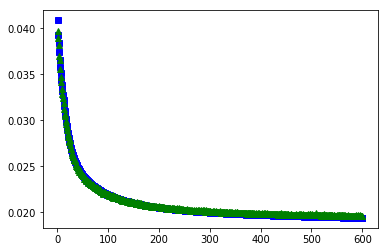

In [23]:
a_epochs = np.arange(1, 1 + len(epoch_train_loss_history))
plt.plot(a_epochs, epoch_train_loss_history, 'bs', a_epochs, epoch_valid_loss_history, 'g^')
plt.show()

### Cálculo da acurácia no conjunto de testes

In [24]:
test_loss = list()
test_label = list()
test_output = list()
test_output_sum = list()

with torch.no_grad():
    for i, samples in enumerate(dataset_test):
        # get the inputs
        image = samples[0].unsqueeze(0).to(device)
        gauss_label = samples[1].unsqueeze(0).to(device)
        test_label.append(samples[2].item())

        # forward
        outputs = model_ce(image)
        loss = crit(outputs, gauss_label)

        test_loss.append(loss.cpu().item())
        test_output.append(outputs.cpu())
        test_output_sum.append(outputs.sum(dim=2).sum(dim=2)[0].cpu().numpy())

In [25]:
test_label_array = np.array(test_label)
test_loss_array = np.array(test_loss)
test_loss_idx = np.argsort(test_loss_array)
test_output_sum_idx = np.array([np.argmax(entry) for entry in test_output_sum])

In [26]:
num_correct_samples = np.sum(test_output_sum_idx == test_label_array)
print(f'Acurácia (pela soma por camada do label): {num_correct_samples * 100.0 / len(test_label_array)}%')

Acurácia (pela soma por camada do label): 99.1%


### Exemplo com menor perda

In [27]:
image_gauss_output = torch.cat((dataset_test[test_loss_idx[0]][0], test_output[test_loss_idx[0]][0]), dim=0)

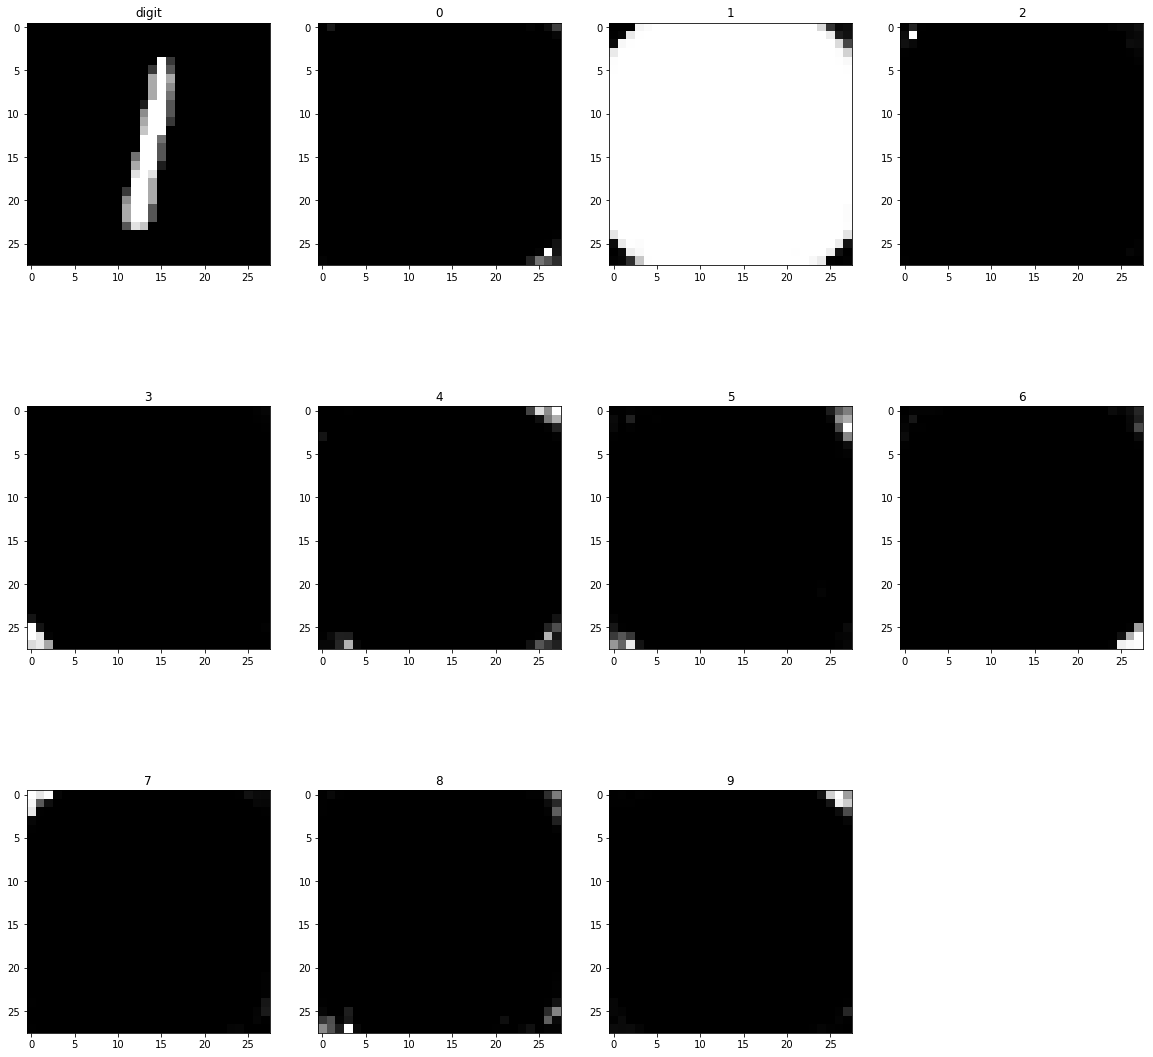

In [28]:
vizGaussNumber(image_gauss_output)

### Exemplo com maior perda

In [29]:
image_gauss_output = torch.cat((dataset_test[test_loss_idx[-1]][0], test_output[test_loss_idx[-1]][0]), dim=0)

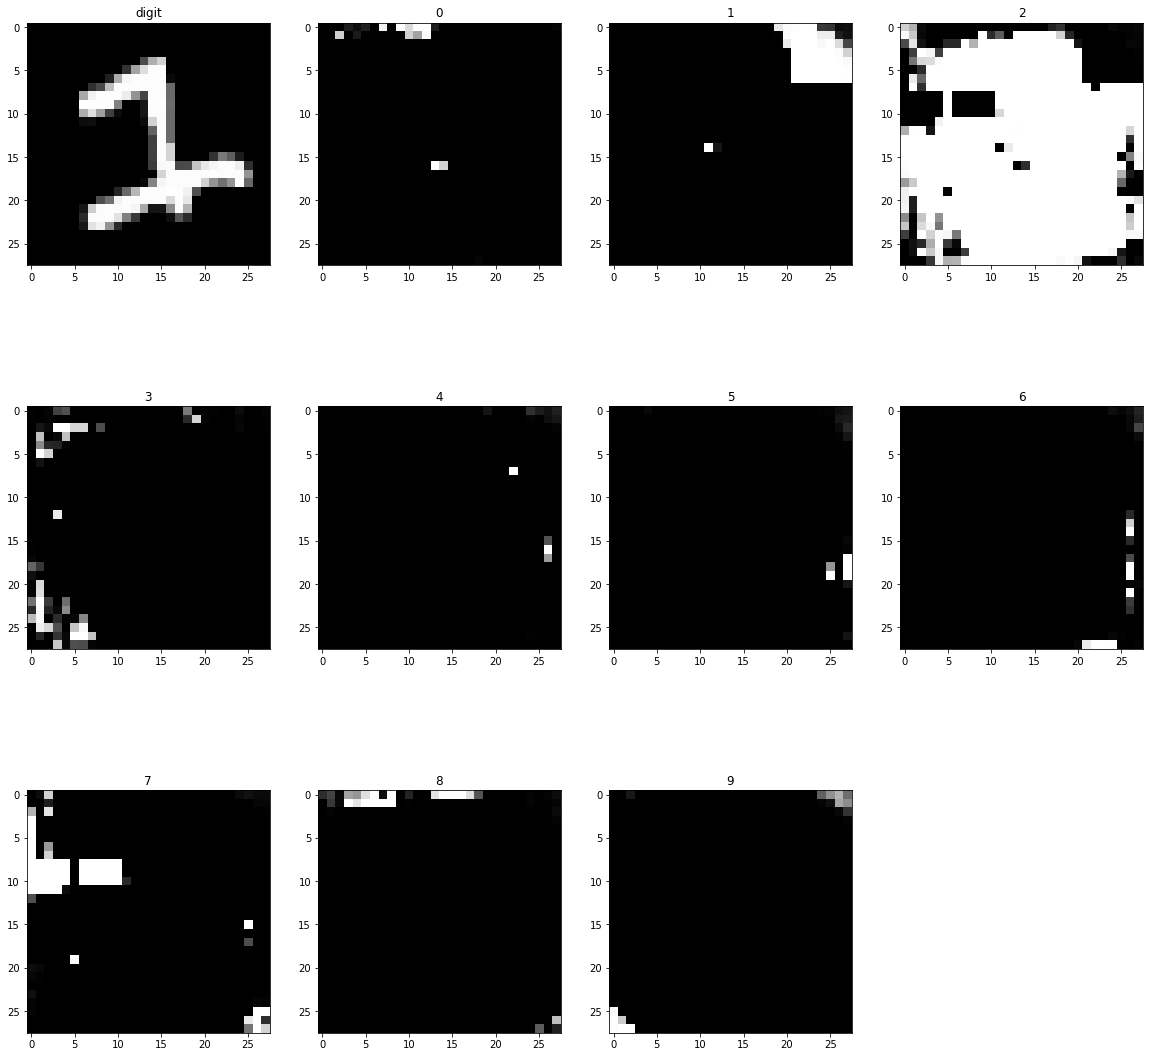

In [30]:
vizGaussNumber(image_gauss_output)

## Predição sobre imagem ampliada com vários dígitos

In [31]:
def matrixMNIST(dataset, output_size, num_h=10, num_w=10, num_digits=10):
    num_cells = num_h * num_w
    cell_indices = np.arange(num_cells)
    np.random.shuffle(cell_indices)
    cell_indices = cell_indices[:np.minimum(num_digits, num_cells)]

    digits_indices = np.arange(len(dataset))
    np.random.shuffle(cell_indices)
    digits_indices = digits_indices[:np.minimum(num_digits, num_cells)]

    matrix_image = torch.zeros((num_h * 28, num_w * 28), dtype=torch.float)
    if output_size == 10:
        matrix_label = torch.ones((output_size, num_h * 28, num_w * 28), dtype=torch.float) / 10.0
    else:
        matrix_label = torch.zeros((output_size, num_h * 28, num_w * 28), dtype=torch.float)
        matrix_label[-1] = 1.0

    for idx in range(len(cell_indices)):
        cell_row = cell_indices[idx] // num_w
        cell_col = cell_indices[idx] % num_w

        sample = dataset[digits_indices[idx]]
        digit_image = sample[0]
        digit_label = sample[1]

        cell_row_start = cell_row * 28
        cell_row_end = cell_row_start + 28
        cell_col_start = cell_col * 28
        cell_col_end = cell_col_start + 28

        matrix_image[cell_row_start:cell_row_end, cell_col_start:cell_col_end] = digit_image[0]
        matrix_label[:, cell_row_start:cell_row_end, cell_col_start:cell_col_end] = digit_label[:]

    return matrix_image, matrix_label

In [32]:
num_h=10
num_w=10

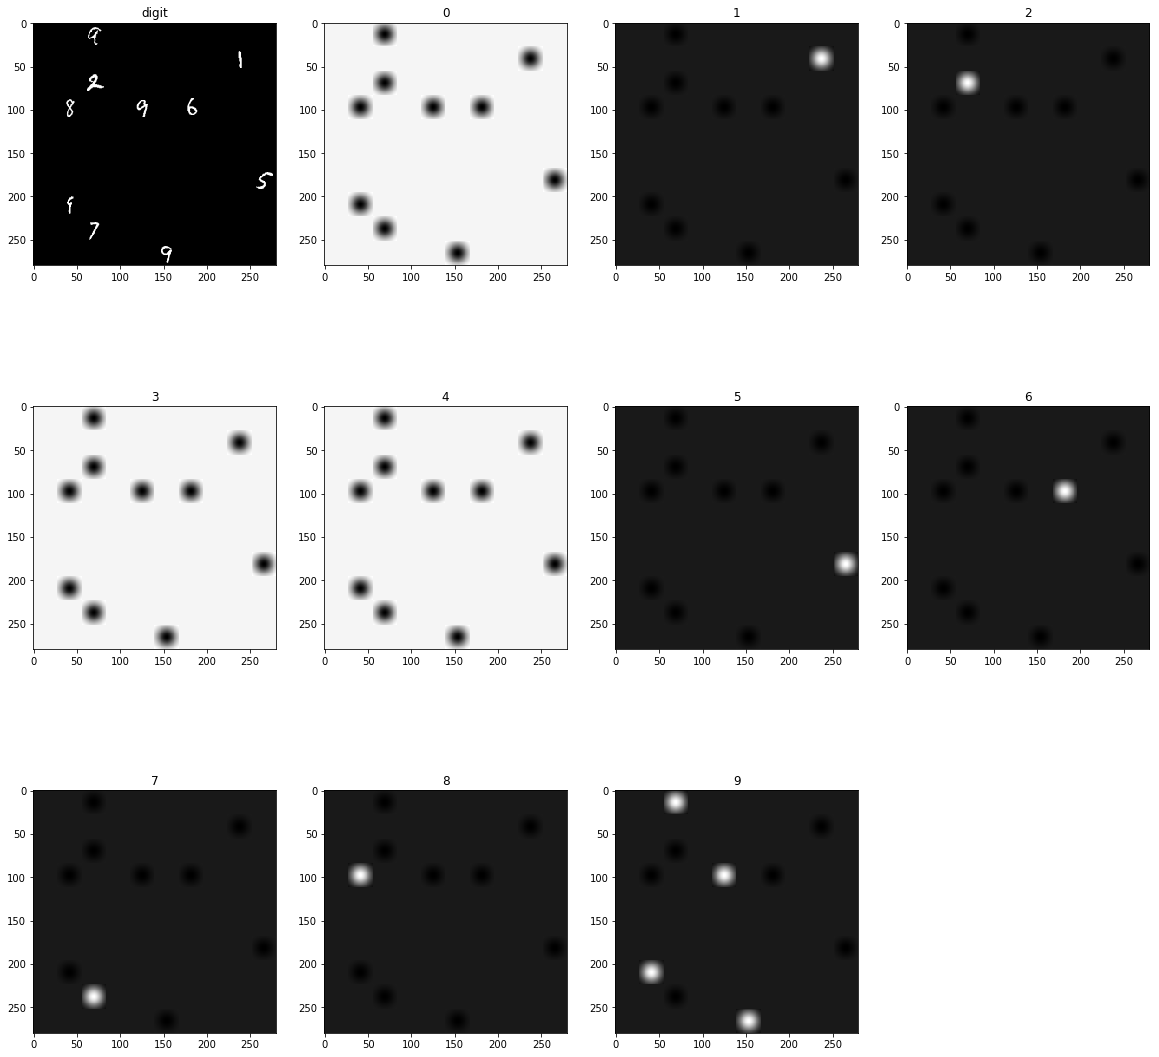

In [33]:
matrix_image, matrix_label = matrixMNIST(dataset_test, model_output_size, num_h=num_h, num_w=num_w)
matrix_image = matrix_image.unsqueeze(0)
matrix_image_gauss_tensor = torch.cat((matrix_image, matrix_label), dim=0)
vizGaussNumber(matrix_image_gauss_tensor)

In [34]:
matrix_image = matrix_image.unsqueeze(0).to(device)
matrix_label = matrix_label.unsqueeze(0).to(device)

with torch.no_grad():
    # forward
    matrix_outputs = model_ce(matrix_image)
    loss = crit(matrix_outputs, matrix_label)

    print(f'Valor da perda: {loss.cpu().item()}')

Valor da perda: 2.24601149559021


In [35]:
matrix_image = matrix_image.cpu()[0]
matrix_outputs = matrix_outputs.cpu()[0]

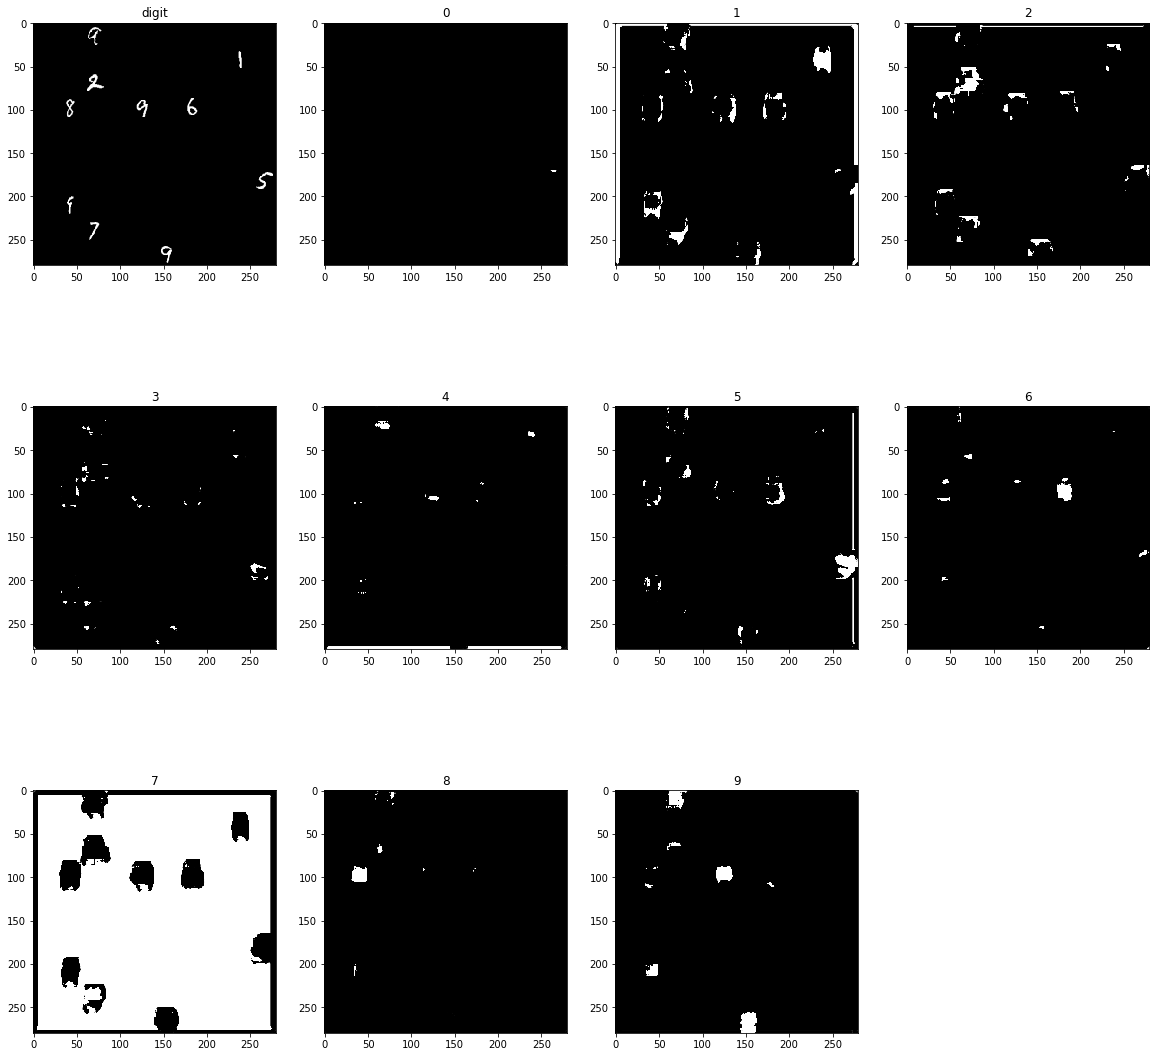

In [36]:
outputs_matrix_image_gauss_tensor = torch.cat((matrix_image, matrix_outputs), dim=0)
vizGaussNumber(outputs_matrix_image_gauss_tensor)

### Determinação de bounding boxes

In [37]:
matrix_outputs_array = matrix_outputs.numpy()

In [38]:
H = num_h * 28
W = num_w * 28
delta_dim = 28 // 2

matrix_outputs_bbox_label = np.empty((H, W), dtype='uint8')
matrix_outputs_bbox_sum = np.empty((H, W), dtype='float')

for row in range(H):
    row_start = np.maximum(0, row - delta_dim)
    row_end = np.minimum(H, row + delta_dim)

    for col in range(W):
        col_start = np.maximum(0, col - delta_dim)
        col_end = np.minimum(H, col + delta_dim)

        matrix_outputs_sum = np.sum(matrix_outputs_array[:, row_start:row_end, col_start:col_end], axis=(1, 2))
        matrix_outputs_bbox_label[row, col] = np.argmax(matrix_outputs_sum, axis=0)
        matrix_outputs_bbox_sum[row, col] = matrix_outputs_sum[matrix_outputs_bbox_label[row, col]]

bbox_threshold = 1
bbox_delta = np.array([[[delta_dim]],[[delta_dim]]])
matrix_outputs_bbox_idx = np.meshgrid(np.linspace(0,W-1,W), np.linspace(0,H-1,H))
matrix_outputs_bbox_start = np.maximum(0, matrix_outputs_bbox_idx - bbox_delta)
matrix_outputs_bbox_end = np.array([np.minimum(W, matrix_outputs_bbox_idx[0] + bbox_delta[0]),
                                    np.minimum(H, matrix_outputs_bbox_idx[1] + bbox_delta[1])])

for row in range(H):
    row_start = np.maximum(0, row - delta_dim)
    row_end = np.minimum(H, row + delta_dim)

    for col in range(W):
        col_start = np.maximum(0, col - delta_dim)
        col_end = np.minimum(H, col + delta_dim)


In [39]:
print(matrix_outputs_bbox_sum[42])

[224.1645813  252.16459656 280.1645813  308.16461182 336.16461182
 364.16461182 392.16461182 420.16461182 448.16461182 476.1645813
 504.1645813  532.16455078 560.16461182 588.16461182 616.16461182
 644.16461182 672.16461182 700.16461182 728.16461182 756.16461182
 784.         784.         784.         784.         784.
 784.         784.         784.         784.         784.
 784.         784.         784.         784.         784.
 784.         784.         784.         784.         784.
 784.         784.         784.         784.         784.
 784.         783.99890137 782.99841309 780.99847412 776.03747559
 770.06994629 763.4788208  755.80517578 746.84094238 737.84094238
 729.70141602 725.15771484 721.15771484 717.15777588 713.15771484
 709.15771484 705.15771484 701.15777588 697.15771484 691.15771484
 682.64465332 674.64648438 668.64648438 664.64715576 664.64697266
 664.64697266 664.64697266 664.64697266 664.64697266 664.64801025
 665.64849854 667.64849854 672.609375   678.5770263